In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired

from hdbscan import HDBSCAN

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# function for wordcloud
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [3]:
# read in data
df_info = pd.read_csv('data/df_info.csv')

df_caption = pd.read_csv('data/df_caption_no_na.csv')

In [4]:
# filter rows 2920 due to its lenght of 1.3 million characters
print(len(df_caption))
df_caption_2 = df_caption[df_caption['caption_char_count'] < 1000000]
print(len(df_caption_2))

3480
3479


In [5]:
# filter out values of df_caption_no_na['caption'] that is not str
print(len(df_caption_2))
df_caption_3 = df_caption_2[df_caption_2['caption'].apply(lambda x: type(x) == str)]
print(len(df_caption_3))

3479
3478


In [6]:
# merge df_caption_3 and df_info[publish date, views, likes ] on id 
df_merge = pd.merge(df_caption_3, df_info, on='id', how='left')

In [7]:
df_merge.isna().sum()

id                         0
json_caption               0
caption                    0
caption_char_count         0
caption_word_count         0
author                    17
title                     17
publish_date              17
views                     17
likes                     17
url                       17
types                     17
length                    17
keywords                  17
description               57
title_char_count          17
title_word_count          17
description_char_count    17
description_word_count    17
days_since_last_video     17
days_since_first_video    17
keyword_count             17
has_keyword               17
dtype: int64

In [8]:
# drop rows with na values
print(len(df_merge))
df_merge = df_merge.dropna()
print(len(df_merge))

3478
3421


# create vectorizer_model, ctfidf_model, representation_model

In [11]:
# create vectorizer
vectorizer = CountVectorizer(stop_words='english')

# create tfidf transformer to reduce frequent words
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# create representation model
representation_model = KeyBERTInspired()

# create hdbscan model
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom',
                        prediction_data=True, min_samples=5)

# load spacy 
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# topic modelling using paraphrase-MiniLM-L6-v2

In [21]:
# bert topic modelling for title
topic_model_base_title = BERTopic(embedding_model="paraphrase-MiniLM-L6-v2", 
                                  calculate_probabilities=True, verbose=True, 
                                  top_n_words=10, n_gram_range=(1,2),
                                  language='en_core_web_lg')
# fit and transform title
title_topic_base, title_prob_base = topic_model_base_title.fit_transform(df_info['title'].to_list())

# get title topic
print(topic_model_base_title.get_topic_info())

# export title topic
topic_model_base_title.get_topic_info().to_csv('data/nlp_output/title_topic_base.csv')

# create column with topic and probability(shape 3663, 65 )
df_info['title_topic'] = title_topic_base
df_info_prep = pd.concat([df_info, pd.DataFrame(title_prob_base)], axis=1)

df_info_prep.to_csv('data/df_info_base.csv', index=False)

# visualize title topic
topic_model_base_title.visualize_topics()

Batches: 100%|██████████| 117/117 [00:29<00:00,  3.98it/s]
2023-03-29 18:56:32,296 - BERTopic - Transformed documents to Embeddings
2023-03-29 18:56:49,682 - BERTopic - Reduced dimensionality
2023-03-29 18:56:51,186 - BERTopic - Clustered reduced embeddings


    Topic  Count                                               Name
0      -1    884                  -1_data_with_science_data science
1       0    186     0_machine learning_machine_learning_of machine
2       1     96        1_data science_science_data_science project
3       2     91            2_pandas_with pandas_missing_dataframes
4       3     90       3_data analyst_analyst_to become_analyst how
..    ...    ...                                                ...
80     79     11       79_data scientist_scientist_being data_being
81     80     11       80_dynamical_chaos_dynamical systems_chaotic
82     81     10  81_opencv_opencv for_python opencv_processing ...
83     82     10          82_using plotly_plotly_plotly excel_chart
84     83     10          83_forza ai_ai using_building forza_forza

[85 rows x 3 columns]


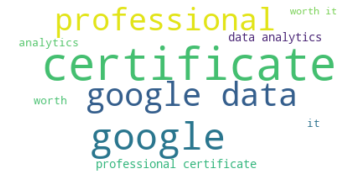

In [25]:
create_wordcloud(topic_model_base_title, topic=24)

In [29]:
topic_model_base_title.visualize_barchart(top_n_topics=12, n_words=5, height=160, width=300)

In [27]:
topics_over_time_base_title = topic_model_base_title.topics_over_time(df_info['title'].to_list(),  
                                                timestamps=df_info['publish_date'].to_list(),  
                                                nr_bins=30)

20it [00:03,  6.49it/s]


In [28]:
topic_model_base_title.visualize_topics_over_time(topics_over_time_base_title, top_n_topics=10)

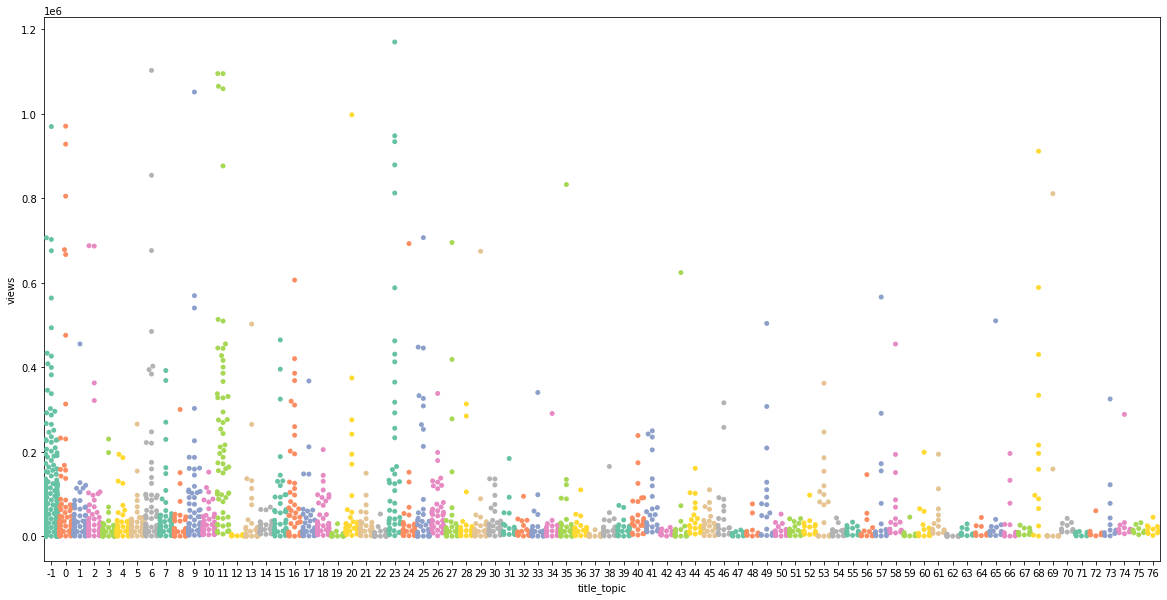

In [30]:
# plot swarmplot for title topic and views removing outliers with more than 1.25 million views
fig_base_title = plt.figure(figsize=(20,10))
ax_base_title = sns.swarmplot(data=df_info[df_info['views'] < 1250000], x='title_topic', y='views'
                   , hue='title_topic', palette='Set2')

# remove legend
ax_base_title.legend_.remove()

In [42]:
# bert topic modelling for caption
topic_model_base_caption = BERTopic(embedding_model="paraphrase-MiniLM-L6-v2", 
                                  calculate_probabilities=True, verbose=True, 
                                  top_n_words=10, n_gram_range=(1,2),
                                  language='en_core_web_lg')
# fit and transform caption
caption_topic_base, caption_prob_base = topic_model_base_caption.fit_transform(df_merge['caption'].to_list())

# get title topic
print(topic_model_base_caption.get_topic_info())

# export title topic
topic_model_base_caption.get_topic_info().to_csv('data/nlp_output/caption_topic_base.csv')

# create column with topic and probability(shape 3663, 65 )
df_merge['caption_topic'] = caption_topic_base
df_caption_prep = pd.concat([df_merge, pd.DataFrame(caption_prob_base)], axis=1)

df_caption_prep.to_csv('data/df_caption_base.csv', index=False)

# visualize title topic
topic_model_base_caption.visualize_topics()

Batches: 100%|██████████| 107/107 [03:06<00:00,  1.74s/it]
2023-03-29 19:45:06,239 - BERTopic - Transformed documents to Embeddings
2023-03-29 19:45:21,875 - BERTopic - Reduced dimensionality
2023-03-29 19:45:22,611 - BERTopic - Clustered reduced embeddings


    Topic  Count                                               Name
0      -1   1182                                  -1_and_to_you_the
1       0    198                                   0_the_we_and_for
2       1    119                                 1_it_you_like_that
3       2    101                                    2_we_and_the_to
4       3     92                                    3_the_we_to_and
5       4     88                                  4_you_that_and_to
6       5     82                                    5_to_the_we_and
7       6     75                              6_will_the_excel_file
8       7     72             7_learning_machine learning_machine_of
9       8     66                                  8_our_we_so_we re
10      9     62                                   9_the_we_data_to
11     10     60                          10_control_system_this_is
12     11     57                               11_the_here_and_will
13     12     56                                

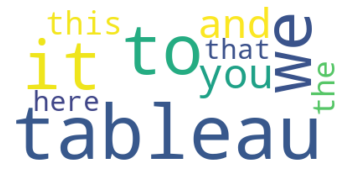

In [45]:
create_wordcloud(topic_model_base_caption, topic=38)

In [46]:
topic_model_base_caption.visualize_barchart(top_n_topics=12, n_words=5, height=160, width=300)

In [47]:
topics_over_time_base_caption = topic_model_base_caption.topics_over_time(df_merge['caption'].to_list(),  
                                                timestamps=df_merge['publish_date'].to_list(),  
                                                nr_bins=30)

30it [11:19, 22.64s/it]


In [49]:
topic_model_base_title.visualize_topics_over_time(topics_over_time_base_caption, top_n_topics=10)

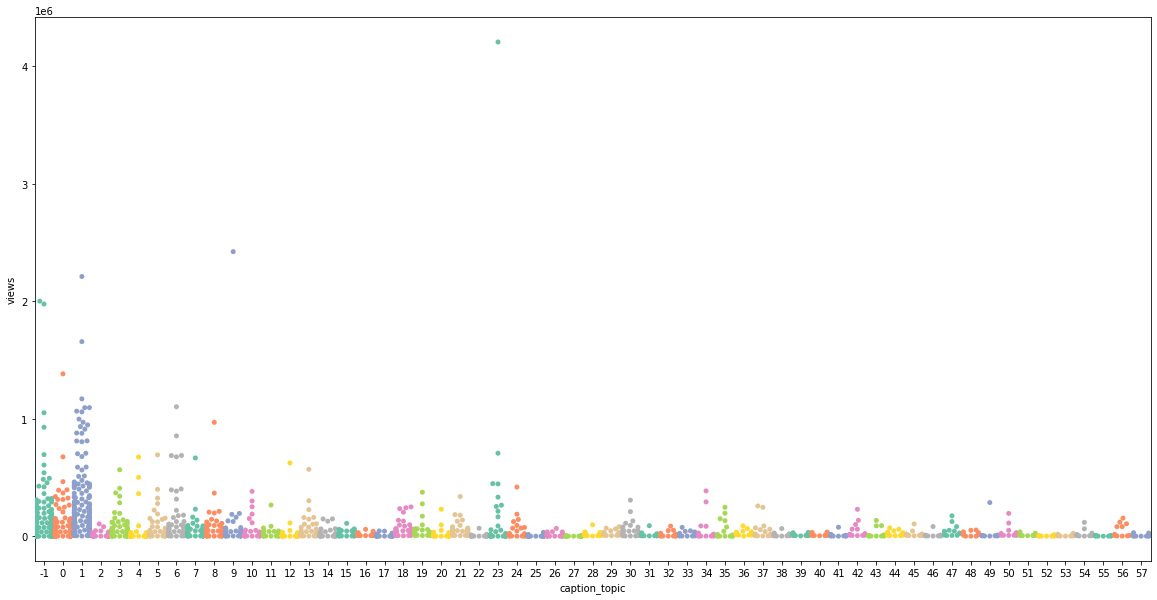

In [ ]:
# plot swarmplot for title topic and views removing outliers with more than 1.25 million views
fig_base_caption = plt.figure(figsize=(20,10))
ax_base_caption = sns.swarmplot(data=df_merge, x='caption_topic', y='views'
                   , hue='caption_topic', palette='Set2')

# remove legend
ax_base_caption.legend_.remove()

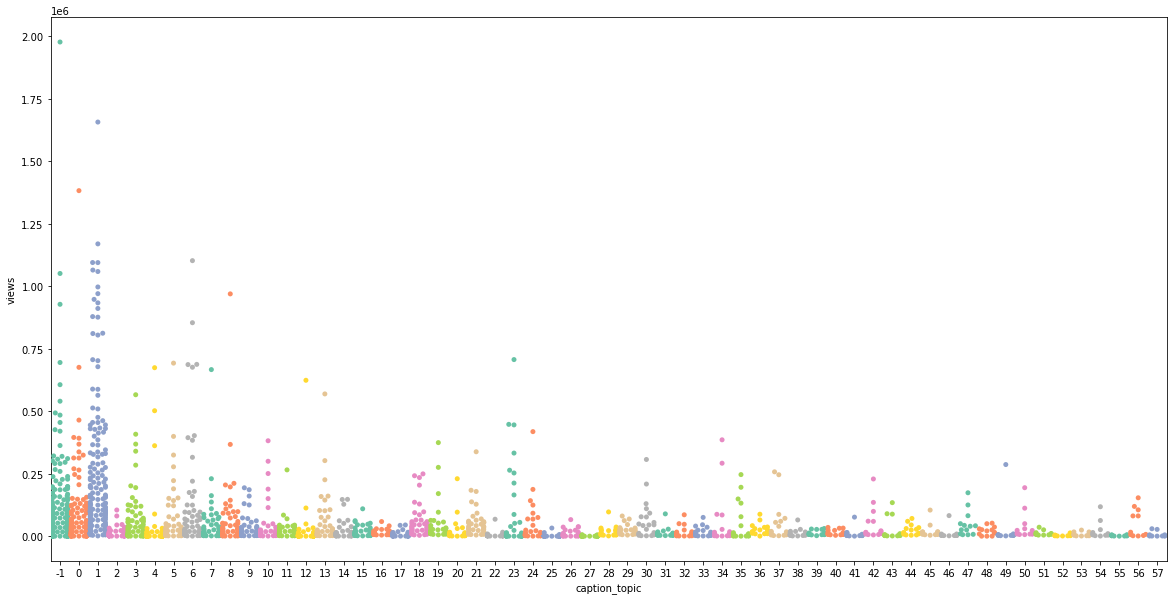

In [49]:
# plot swarmplot for title topic and views removing outliers with more than 2 million views
fig_base_caption = plt.figure(figsize=(20,10))
ax_base_caption = sns.swarmplot(data=df_merge[df_merge['views'] < 2000000], x='caption_topic', y='views'
                     , hue='caption_topic', palette='Set2')
                    

# remove legend
ax_base_caption.legend_.remove()

# caption using base with ctfidf

In [31]:
# bert topic modelling for caption
topic_model_base_caption2 = BERTopic(embedding_model="paraphrase-MiniLM-L6-v2", 
                                  calculate_probabilities=True, verbose=True, 
                                  top_n_words=10, n_gram_range=(1,2),
                                  language='en_core_web_lg', ctfidf_model=ctfidf_model,
                                  vectorizer_model=vectorizer)
# fit and transform caption
caption_topic_base2, caption_prob_base2 = topic_model_base_caption2.fit_transform(df_merge['caption'].to_list())

# get title topic
print(topic_model_base_caption2.get_topic_info())

# export title topic
topic_model_base_caption2.get_topic_info().to_csv('data/nlp_output/caption_topic_base2.csv')

# create column with topic and probability(shape 3663, 65 )
df_merge['caption_topic'] = caption_topic_base2
df_caption_prep = pd.concat([df_merge, pd.DataFrame(caption_prob_base2)], axis=1)

df_caption_prep.to_csv('data/df_caption_base2.csv', index=False)

# visualize title topic
topic_model_base_caption2.visualize_topics()

Batches: 100%|██████████| 107/107 [02:34<00:00,  1.45s/it]
2023-03-29 23:16:34,027 - BERTopic - Transformed documents to Embeddings
2023-03-29 23:16:45,560 - BERTopic - Reduced dimensionality
2023-03-29 23:16:46,142 - BERTopic - Clustered reduced embeddings


    Topic  Count                                              Name
0      -1    909                  -1_model_kind_learning_basically
1       0    313          0_science_scientist_scientists_engineers
2       1    197                        1_quest_stat_bam_residuals
3       2    133                             2_oh_yeah_stream_chat
4       3     99                         3_list_enter_python_print
5       4     94                   4_analyst_job_interview_company
6       5     93             5_network_normalization_layer_neurons
7       6     82                   6_excel_workbook_file_worksheet
8       7     78                       7_tensor_tf_shape_wonderful
9       8     77                           8_leg_body_push_workout
10      9     74                   9_machine_learning_ml_algorithm
11     10     68             10_detection_effectively_images_image
12     11     66                        11_delta_minus_lambda_plus
13     12     64  12_control_controllability_dynamics_controll

# caption using mpnet embedding and vectorizer

In [28]:
# bert topic modelling for caption
topic_model_mpnet_caption = BERTopic(embedding_model="all-mpnet-base-v2", 
                                  calculate_probabilities=True, verbose=True, 
                                  top_n_words=10, n_gram_range=(1,2),
                                  language='en_core_web_lg', vectorizer_model=vectorizer)
# fit and transform caption
caption_topic_mpnet, caption_prob_mpnet = topic_model_mpnet_caption.fit_transform(df_merge['caption'].to_list())

# get title topic
print(topic_model_mpnet_caption.get_topic_info())

# export title topic
topic_model_mpnet_caption.get_topic_info().to_csv('data/nlp_output/caption_topic_mpnet.csv')

# create column with topic and probability(shape 3663, 65 )
df_merge['caption_topic'] = caption_topic_mpnet
df_caption_prep = pd.concat([df_merge, pd.DataFrame(caption_prob_mpnet)], axis=1)

df_caption_prep.to_csv('data/df_caption_mpnet.csv', index=False)

# visualize title topic
topic_model_mpnet_caption.visualize_topics()

Batches: 100%|██████████| 107/107 [42:51<00:00, 24.03s/it]
2023-03-29 22:55:34,813 - BERTopic - Transformed documents to Embeddings
2023-03-29 22:55:48,601 - BERTopic - Reduced dimensionality
2023-03-29 22:55:49,538 - BERTopic - Clustered reduced embeddings


    Topic  Count                                       Name
0      -1    954                     -1_like_data_know_just
1       0    112                      0_day_ve_got_learning
2       1    103                           1_um_like_uh_don
3       2    100                          2_um_like_uh_know
4       3     84          3_machine_learning_algorithm_data
..    ...    ...                                        ...
75     74     12  74_intelligence_artificial_project_search
76     75     12                 75_pc_pca_dimensional_umap
77     76     11               76_iris_set_prediction_model
78     77     11          77_analytic_complex_partial_theta
79     78     10            78_course_analyst_courses_learn

[80 rows x 3 columns]


NameError: name 'topic_model_base_caption' is not defined

In [29]:
topic_model_mpnet_caption.visualize_topics()

# topic modelling using spacy

In [29]:
topic_model_nlp_title = BERTopic(embedding_model=nlp, calculate_probabilities=True, 
                           verbose=True, top_n_words=10, n_gram_range=(1,2),
                           language='en_core_web_lg')

# fit and transform title
title_topic_nlp, title_prob_nlp = topic_model_nlp_title.fit_transform(df_info['title'].to_list())

# get title topic
print(topic_model_nlp_title.get_topic_info())

# export title topic
topic_model_nlp_title.get_topic_info().to_csv('data/nlp_output/title_topic_spacy.csv')

# create column with topic and probability(shape 3663, 65 )
df_info['title_topic'] = title_topic_nlp
df_info_prep = pd.concat([df_info, pd.DataFrame(title_prob_nlp)], axis=1)

df_info_prep.to_csv('data/df_info_spacy.csv', index=False)

# visualize title topic
topic_model_nlp_title.visualize_topics()

100%|██████████| 3713/3713 [00:18<00:00, 198.69it/s]
2023-03-29 19:11:56,608 - BERTopic - Transformed documents to Embeddings
2023-03-29 19:12:14,610 - BERTopic - Reduced dimensionality
2023-03-29 19:12:16,127 - BERTopic - Clustered reduced embeddings


    Topic  Count                                               Name
0      -1   1378                            -1_data_to_with_science
1       0    137          0_lecture_equation_equations_differential
2       1    124          1_data analyst_analyst_become data_become
3       2    103  2_clearly_clearly explained_explained_explaine...
4       3     95   3_neural_neural networks_networks_neural network
..    ...    ...                                                ...
70     69     12                 69_tried_in 15_15 minutes_tried to
71     70     11             70_mito_python with_mito how_with mito
72     71     11                        71_bi_power bi_power_bi for
73     72     11  72_website_portfolio website_portfolio_website...
74     73     10   73_your portfolio_top data_projects for_for your

[75 rows x 3 columns]


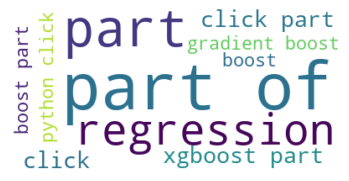

In [34]:
create_wordcloud(topic_model_nlp_title, topic=46)

In [50]:
topics_over_time_nlp_title = topic_model_nlp_title.topics_over_time(df_info['title'].to_list(),  
                                                timestamps=df_info['publish_date'].to_list(),  
                                                nr_bins=30)

20it [00:02,  6.81it/s]


In [51]:
topic_model_nlp_title.visualize_topics_over_time(topics_over_time_nlp_title, top_n_topics=10)

In [52]:
topic_model_nlp_title.visualize_barchart(top_n_topics=12, n_words=5, height=160, width=300)

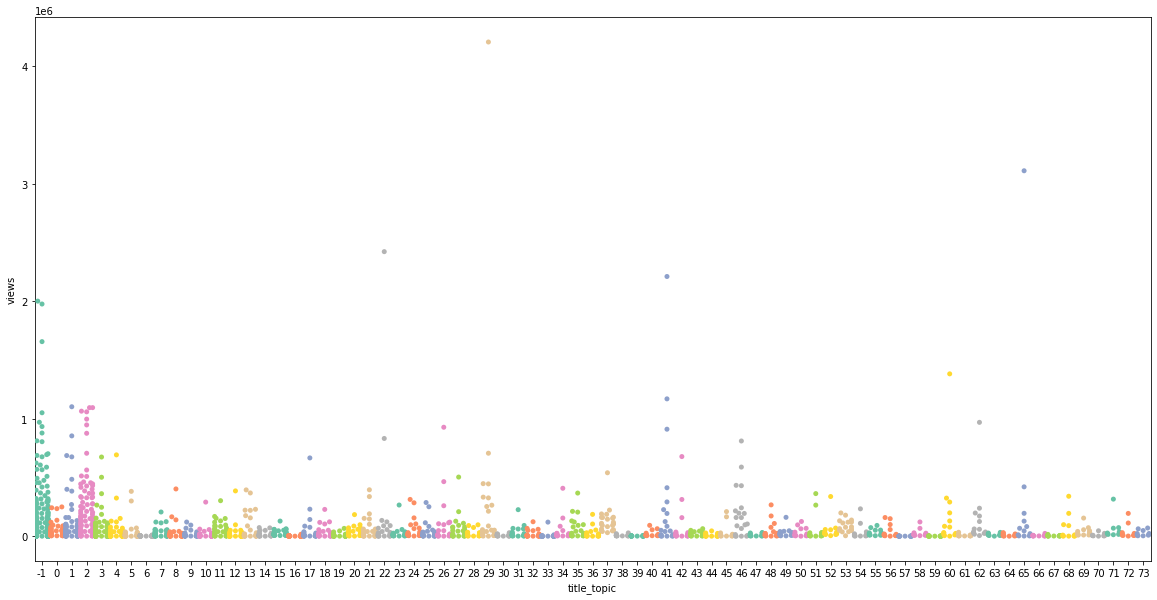

In [36]:
# plot swarmplot for title topic and views removing outliers with more than 1.25 million views
fig = plt.figure(figsize=(20,10))
ax = sns.swarmplot(data=df_info, x='title_topic', y='views'
                   , hue='title_topic', palette='Set2')

# remove legend
ax.legend_.remove()

In [53]:
# bert topic modelling for caption
topic_model_spacy_caption = BERTopic(embedding_model=nlp, calculate_probabilities=True, 
                           verbose=True, top_n_words=10, n_gram_range=(1,2),
                           language='en_core_web_lg')
# fit and transform caption
caption_topic_spacy, caption_prob_spacy = topic_model_spacy_caption.fit_transform(df_merge['caption'].to_list())

# get title topic
print(topic_model_spacy_caption.get_topic_info())

# export title topic
topic_model_spacy_caption.get_topic_info().to_csv('data/nlp_output/caption_topic_spacy.csv')

# create column with topic and probability(shape 3663, 65 )
df_merge['caption_topic'] = caption_topic_spacy
df_caption_prep = pd.concat([df_merge, pd.DataFrame(caption_prob_spacy)], axis=1)

df_caption_prep.to_csv('data/df_caption_spacy.csv', index=False)

# visualize title topic
topic_model_spacy_caption.visualize_topics()

100%|██████████| 3421/3421 [16:56<00:00,  3.36it/s]  
2023-03-29 20:23:10,255 - BERTopic - Transformed documents to Embeddings
2023-03-29 20:23:34,419 - BERTopic - Reduced dimensionality
2023-03-29 20:23:35,340 - BERTopic - Clustered reduced embeddings


    Topic  Count                                            Name
0      -1   1071                               -1_to_you_and_the
1       0    383                                0_this_of_is_the
2       1    138                              1_the_we_quest_for
3       2    123                             2_the_and_here_will
4       3    119                                3_um_like_you_uh
..    ...    ...                                             ...
58     57     12                          57_image_the_images_is
59     58     11  58_overfitting_regularization_your model_model
60     59     11                        59_we_going to_going_and
61     60     11    60_music_music music_applause_applause music
62     61     10                         61_shots_the_point_shot

[63 rows x 3 columns]


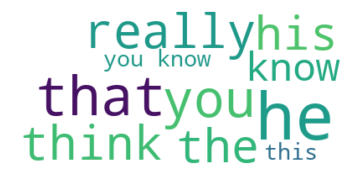

In [51]:
create_wordcloud(topic_model_spacy_caption, topic=28)

In [53]:
topics_over_time_spacy_caption = topic_model_spacy_caption.topics_over_time(df_merge['caption'].to_list(),  
                                                timestamps=df_merge['publish_date'].to_list(),  
                                                nr_bins=30)

30it [08:55, 17.84s/it]


In [54]:
topic_model_spacy_caption.visualize_topics_over_time(topics_over_time_spacy_caption, top_n_topics=10)

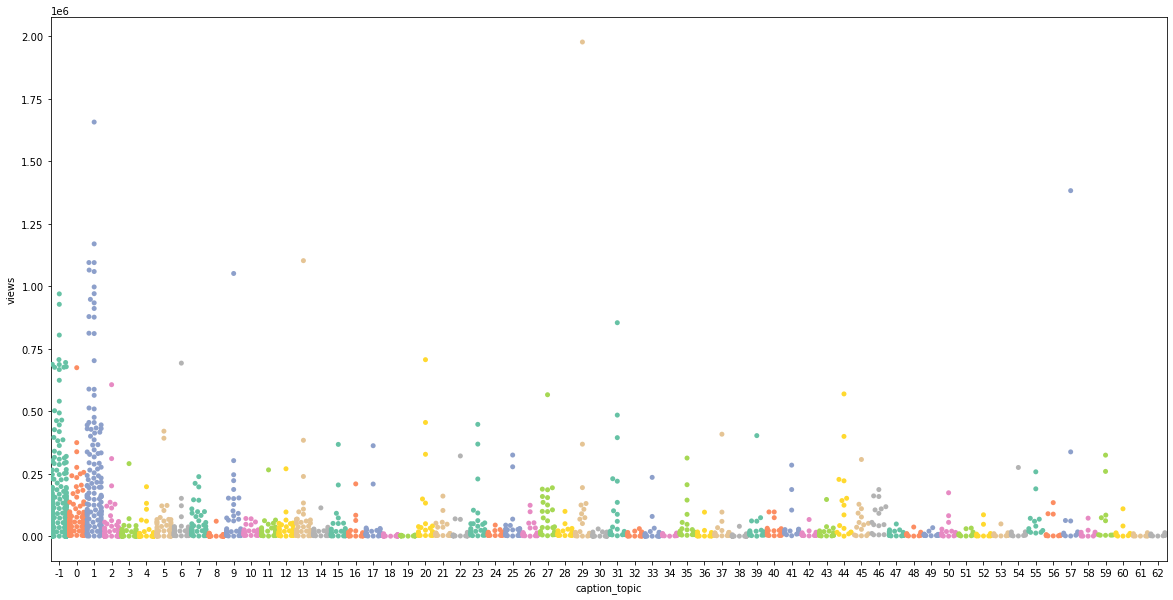

In [55]:
# plot swarmplot for title topic and views removing outliers with more than 2 million views
fig_spacy_caption = plt.figure(figsize=(20,10))
ax_spacy_caption = sns.swarmplot(data=df_merge[df_merge['views'] < 2000000], x='caption_topic', y='views'
                     , hue='caption_topic', palette='Set2')
                    

# remove legend
ax_spacy_caption.legend_.remove()

In [32]:
# bert topic modelling for caption
topic_model_spacy_caption2 = BERTopic(embedding_model=nlp, calculate_probabilities=False, 
                           verbose=True, top_n_words=10, n_gram_range=(1,2),
                           language='en_core_web_lg', vectorizer_model=vectorizer, 
                           ctfidf_model=ctfidf_model)
# fit and transform caption
caption_topic_spacy2, caption_prob_spacy2 = topic_model_spacy_caption2.fit_transform(df_merge['caption'].to_list())

# get title topic
print(topic_model_spacy_caption2.get_topic_info())

# export title topic
topic_model_spacy_caption2.get_topic_info().to_csv('data/nlp_output/caption_topic_spacy3.csv')

# create column with topic and probability(shape 3663, 65 )
df_merge['caption_topic'] = caption_topic_spacy2
df_caption_prep = pd.concat([df_merge, pd.DataFrame(caption_prob_spacy2)], axis=1)

df_caption_prep.to_csv('data/df_caption_spacy3.csv', index=False)

# visualize title topic
topic_model_spacy_caption2.visualize_topics()

100%|██████████| 3421/3421 [12:13<00:00,  4.67it/s]
2023-03-29 23:36:43,644 - BERTopic - Transformed documents to Embeddings
2023-03-29 23:36:54,842 - BERTopic - Reduced dimensionality
2023-03-29 23:36:54,964 - BERTopic - Clustered reduced embeddings


    Topic  Count                                     Name
0      -1   1173   -1_machine_learning_environment_things
1       0    139              0_quest_gene_residuals_stat
2       1    117                    1_web_input_app_shown
3       2     96             2_tensor_tf_predictions_tree
4       3     90  3_udacity_intelligence_music_artificial
..    ...    ...                                      ...
62     61     11               61_shots_strokes_odds_shot
63     62     10      62_stage_courses_science_foundation
64     63     10   63_libraries_speech_numpy_conditionals
65     64     10           64_centroids_self_cluster_loss
66     65     10            65_sold_apocalypse_bins_sales

[67 rows x 3 columns]


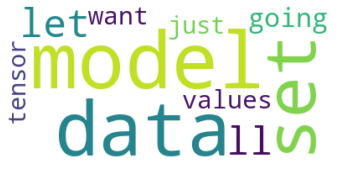

In [27]:
create_wordcloud(topic_model_spacy_caption2, topic=3)